In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import cv2
import os
from nltk import wordpunct_tokenize
import re

In [ ]:
!gdown 1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD

Downloading...
From: https://drive.google.com/uc?id=1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD
To: /content/ml1m.zip
100% 105M/105M [00:00<00:00, 229MB/s] 


In [ ]:
!unzip -qq -n ml1m.zip -d ml1m

In [ ]:
# You need extract file ml1m.zip to folder ml1m before run code
# đọc dữ liệu từ dataset
users = pd.read_csv('ml1m/content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pd.read_csv('ml1m/content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pd.read_csv('ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_test = pd.read_csv('ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

In [ ]:
movies_1 = pd.concat([movies_train, movies_test])
genre_all = []
genre_list = movies_1['genre']

for genres in genre_list:

    for genre in genres:
        genre_all.append(genre)

uniq, counts = np.unique(genre_all, return_counts=True)
print("Number of unique genres:", len(uniq))
print("Unique genres are:", uniq)
dict(zip(uniq, counts))

Number of unique genres: 18
Unique genres are: ['Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']


{'Action': 503,
 'Adventure': 283,
 'Animation': 105,
 "Children's": 251,
 'Comedy': 1200,
 'Crime': 211,
 'Documentary': 127,
 'Drama': 1603,
 'Fantasy': 68,
 'Film-Noir': 44,
 'Horror': 343,
 'Musical': 114,
 'Mystery': 106,
 'Romance': 471,
 'Sci-Fi': 276,
 'Thriller': 492,
 'War': 143,
 'Western': 68}

# Dataset

In [ ]:
folder_img_path = 'ml1m/content/dataset/ml1m-images'
movies_train['id'] = movies_train.index
movies_train.reset_index(inplace=True)
movies_train['img_path'] = movies_train.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg'), axis = 1)
movies_train

,movieid,title,genre,id,img_path
0,1650,Washington Square (1997),[Drama],1650,ml1m/content/dataset/ml1m-images/1650.jpg
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",185,ml1m/content/dataset/ml1m-images/185.jpg
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",1377,ml1m/content/dataset/ml1m-images/1377.jpg
3,3204,"Boys from Brazil, The (1978)",[Thriller],3204,ml1m/content/dataset/ml1m-images/3204.jpg
4,1901,Dear Jesse (1997),[Documentary],1901,ml1m/content/dataset/ml1m-images/1901.jpg
...,...,...,...,...,...
3101,2539,Analyze This (1999),[Comedy],2539,ml1m/content/dataset/ml1m-images/2539.jpg
3102,3038,"Face in the Crowd, A (1957)",[Drama],3038,ml1m/content/dataset/ml1m-images/3038.jpg
3103,1832,Heaven's Burning (1997),"[Action, Drama]",1832,ml1m/content/dataset/ml1m-images/1832.jpg
3104,657,Yankee Zulu (1994),"[Comedy, Drama]",657,ml1m/content/dataset/ml1m-images/657.jpg


In [ ]:
folder_img_path = 'ml1m/content/dataset/ml1m-images'
movies_test['id'] = movies_test.index
movies_test.reset_index(inplace=True)
movies_test['img_path'] = movies_test.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg'), axis = 1)
movies_test

,movieid,title,genre,id,img_path
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",3397,ml1m/content/dataset/ml1m-images/3397.jpg
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",2067,ml1m/content/dataset/ml1m-images/2067.jpg
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],2651,ml1m/content/dataset/ml1m-images/2651.jpg
3,2989,For Your Eyes Only (1981),[Action],2989,ml1m/content/dataset/ml1m-images/2989.jpg
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],3415,ml1m/content/dataset/ml1m-images/3415.jpg
...,...,...,...,...,...
772,2309,"Inheritors, The (Die Siebtelbauern) (1998)",[Drama],2309,ml1m/content/dataset/ml1m-images/2309.jpg
773,2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]",2421,ml1m/content/dataset/ml1m-images/2421.jpg
774,3255,"League of Their Own, A (1992)","[Comedy, Drama]",3255,ml1m/content/dataset/ml1m-images/3255.jpg
775,974,Algiers (1938),"[Drama, Romance]",974,ml1m/content/dataset/ml1m-images/974.jpg


In [ ]:
def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = wordpunct_tokenize(text)
    tokens = tokens[:-1]
    return tokens

def create_vocab():
    df = movies_train.copy()
    arr_title = df['title'].tolist()
    vocab = set()
    for title in arr_title:
        tokens = tokenize(title)
        vocab.update(tokens)
    vocab = list(vocab)
    pad_token = '<PAD>'
    unk_token = '<UNK>'
    vocab.append(pad_token)
    vocab.append(unk_token)
    return vocab

In [ ]:
class MLDataset(Dataset):
    def __init__(self, is_train=True):
        if is_train:
            self.data = movies_train
        else:
            self.data = movies_test
        self.data['title_tokens'] = [tokenize(x) for x in self.data.title]

        # create vocab
        vocab = create_vocab()
        pad_token = '<PAD>'
        unk_token = '<UNK>'
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}

        # Create a binary vector for each word in each sentence
        MAX_LENGTH = 7
        vectors = []
        for title_tokens in self.data.title_tokens.tolist():
            if len(title_tokens) < MAX_LENGTH:
                num_pad = MAX_LENGTH - len(title_tokens)
                for idx in range(num_pad):
                    title_tokens.append(pad_token)
            else:
                title_tokens = title_tokens[:MAX_LENGTH]
            title_vectors = []
            for word in title_tokens:
                binary_vector = np.zeros(len(vocab))
                if word in vocab:
                    binary_vector[self.token2idx[word]] = 1
                else:
                    binary_vector[self.token2idx[unk_token]] = 1
                title_vectors.append(binary_vector)

            vectors.append(np.array(title_vectors))
        self.data['vectors'] = vectors

        # label genre
        with open('ml1m/content/dataset/genres.txt', 'r') as f:
            genre_all = f.readlines()
            genre_all = [x.replace('\n', '') for x in genre_all]
        self.genre2idx = {genre: idx for idx, genre in enumerate(genre_all)}

    def __getitem__(self, index):
        title = self.data.iloc[index].title
        img_path = self.data.iloc[index].img_path
        genre = self.data.iloc[index].genre

        # preprocess img
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
        else:
            img = np.random.rand(256, 256, 3)
        img = cv2.resize(img, (256, 256))
        img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float()

        # preprocess text
        title_vector = self.data.iloc[index].vectors
        title_tensor = torch.from_numpy(title_vector).float()

        # preprocess label
        num_classes = len(self.genre2idx)
        genre_indices = [self.genre2idx[g] for g in genre]
        genre_one_hot = np.zeros(num_classes)
        genre_one_hot[genre_indices] = 1
        genre_tensor = torch.from_numpy(genre_one_hot).float()

        return title_tensor, img_tensor, genre_tensor

    def __len__(self):
        return len(self.data)

In [ ]:
train_set = MLDataset(is_train=True)
test_set = MLDataset(is_train=False)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [ ]:
#dạng của các tensor
test_set.__getitem__(100)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]]),
 tensor([[[42., 31., 21.,  ...,  3.,  3.,  3.],
          [26., 21., 17.,  ...,  2.,  2.,  2.],
          [26., 25., 24.,  ...,  1.,  1.,  1.],
          ...,
          [31., 32., 32.,  ..., 30., 30., 30.],
          [36., 35., 34.,  ..., 30., 30., 30.],
          [38., 37., 36.,  ..., 32., 32., 32.]],
 
         [[38., 27., 17.,  ...,  3.,  3.,  3.],
          [22., 17., 13.,  ...,  2.,  2.,  2.],
          [22., 20., 20.,  ...,  1.,  1.,  1.],
          ...,
          [30., 30., 30.,  ..., 29., 29., 29.],
          [35., 34., 33.,  ..., 28., 28., 28.],
          [37., 36., 35.,  ..., 29., 29., 29.]],
 
         [[37., 26., 16.,  ...,  3.,  3.,  3.],
          [21., 16., 12.,  ...,  2.,  2.,  2.],
          [21., 19., 19.,  ...

In [ ]:
for title_tensor, img_tensor, genre_tensor in train_dataloader:
    print(title_tensor.shape, img_tensor.shape, genre_tensor.shape)
    break
for title_tensor, img_tensor, genre_tensor in test_dataloader:
    print(title_tensor.shape, img_tensor.shape, genre_tensor.shape)
    break

torch.Size([32, 7, 3899]) torch.Size([32, 3, 256, 256]) torch.Size([32, 18])
torch.Size([32, 7, 3899]) torch.Size([32, 3, 256, 256]) torch.Size([32, 18])


# Model

In [ ]:
with open('ml1m/content/dataset/genres.txt', 'r') as f:
    genre_all = f.readlines()
num_classes = len(genre_all)
num_classes

18

In [ ]:
import torch.nn.functional as F

class BaseModel(nn.Module):
    def __init__(self, num_classes, len_vocab, embedding_dimension=3898, hidden_size=64, dropout_rate=0.4):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size

        # img
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 128, hidden_size)

        # text
        self.fc2 = nn.Linear(7 * len_vocab, hidden_size)


        self.dropout_img = nn.Dropout(p=dropout_rate)
        self.dropout_text = nn.Dropout(p=dropout_rate)

        # Fully connected layer after concatenating text and img features
        self.fc3 = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, text_tens, img_tens):
        # Process text features
        text_feat = F.relu(self.fc2(self.dropout_text(self.flatten(text_tens))))

        # Process image features
        img_feat = self.conv1(img_tens)
        img_feat = F.relu(self.maxpool(img_feat))
        img_feat = self.conv2(img_feat)
        img_feat = F.relu(self.fc1(self.dropout_img(self.flatten(img_feat))))

        # Concatenate text and image features
        combined_feat = torch.cat([text_feat, img_feat], dim=1)

        # Final output
        out = self.fc3(combined_feat)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab = create_vocab()
model = BaseModel(num_classes, len(vocab)).to(device)

title_tensor = title_tensor.to(device)
img_tensor = img_tensor.to(device)

out = model(title_tensor, img_tensor)
out.shape

torch.Size([32, 18])

# Loss

In [ ]:
from torch import optim
criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3

# Training

In [ ]:
def calculate_accuracy(predictions, targets):
    predictions = torch.sigmoid(predictions)
    binary_predictions = predictions > 0.5
    correct = binary_predictions.eq(targets.byte())
    accuracy = correct.float().mean().item()
    return accuracy

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MultilabelF1Score
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.7 MB/s eta 0:00:00


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
NUM_EP = 15

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# Training loop
for epoch in range(NUM_EP):
    model.train()
    total_loss = 0
    total_accuracy = 0

    for title_tensor, img_tensor, genre_tensor in train_dataloader:
        title_tensor = title_tensor.to(device)
        img_tensor = img_tensor.to(device)
        genre_tensor = genre_tensor.to(device)

        optimizer.zero_grad()

        out = model(title_tensor, img_tensor)
        loss = criterion(out, genre_tensor)
        accuracy = calculate_accuracy(out, genre_tensor)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy

    average_loss = total_loss / len(train_dataloader)
    average_accuracy = total_accuracy / len(train_dataloader)

    train_loss_list.append(average_loss)
    train_acc_list.append(average_accuracy)

    print(f'\nEpoch {epoch + 1}/{NUM_EP}, '
          f'Loss: {average_loss:.4f}, '
          f'Accuracy: {average_accuracy:.4f}', end=(' '))

    # Validation loop
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_val_accuracy = 0

        for title_tensor, img_tensor, genre_tensor in test_dataloader:
            title_tensor = title_tensor.to(device)
            img_tensor = img_tensor.to(device)
            genre_tensor = genre_tensor.to(device)

            val_out = model(title_tensor, img_tensor)
            val_loss = criterion(val_out, genre_tensor)
            val_accuracy = calculate_accuracy(val_out, genre_tensor)

            total_val_loss += val_loss.item()
            total_val_accuracy += val_accuracy

        average_val_loss = total_val_loss / len(test_dataloader)
        average_val_accuracy = total_val_accuracy / len(test_dataloader)

        val_loss_list.append(average_val_loss)
        val_acc_list.append(average_val_accuracy)
        print(
              f'Val_Loss: {average_val_loss:.4f}, '
              f'Val_Accuracy: {average_val_accuracy:.4f}')


Epoch 1/15, Loss: 4.6645, Accuracy: 0.8438 Val_Loss: 0.2857, Val_Accuracy: 0.9119

Epoch 2/15, Loss: 0.2958, Accuracy: 0.9060 Val_Loss: 0.2538, Val_Accuracy: 0.9121

Epoch 3/15, Loss: 0.2832, Accuracy: 0.9063 Val_Loss: 0.2488, Val_Accuracy: 0.9121

Epoch 4/15, Loss: 0.2658, Accuracy: 0.9064 Val_Loss: 0.2465, Val_Accuracy: 0.9121

Epoch 5/15, Loss: 0.2540, Accuracy: 0.9072 Val_Loss: 0.2442, Val_Accuracy: 0.9121

Epoch 6/15, Loss: 0.2416, Accuracy: 0.9106 Val_Loss: 0.2425, Val_Accuracy: 0.9122

Epoch 7/15, Loss: 0.2305, Accuracy: 0.9159 Val_Loss: 0.2406, Val_Accuracy: 0.9122

Epoch 8/15, Loss: 0.2178, Accuracy: 0.9208 Val_Loss: 0.2388, Val_Accuracy: 0.9117

Epoch 9/15, Loss: 0.2055, Accuracy: 0.9253 Val_Loss: 0.2372, Val_Accuracy: 0.9123

Epoch 10/15, Loss: 0.1930, Accuracy: 0.9301 Val_Loss: 0.2361, Val_Accuracy: 0.9126

Epoch 11/15, Loss: 0.1818, Accuracy: 0.9345 Val_Loss: 0.2348, Val_Accuracy: 0.9128

Epoch 12/15, Loss: 0.1693, Accuracy: 0.9402 Val_Loss: 0.2344, Val_Accuracy: 0.9133



In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for title_tensor, img_tensor, genre_tensor in dataloader:
            title_tensor = title_tensor.to(device)
            img_tensor = img_tensor.to(device)

            # Thực hiện dự đoán
            out = model(title_tensor, img_tensor)
            predictions.append(out.cpu())
            labels.append(genre_tensor.cpu())

    predictions = torch.sigmoid(torch.cat(predictions)).numpy()
    labels = torch.cat(labels).numpy()

    return predictions, labels



def plot_metrics(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
    plt.figure(figsize=(12, 4))


    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Train Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

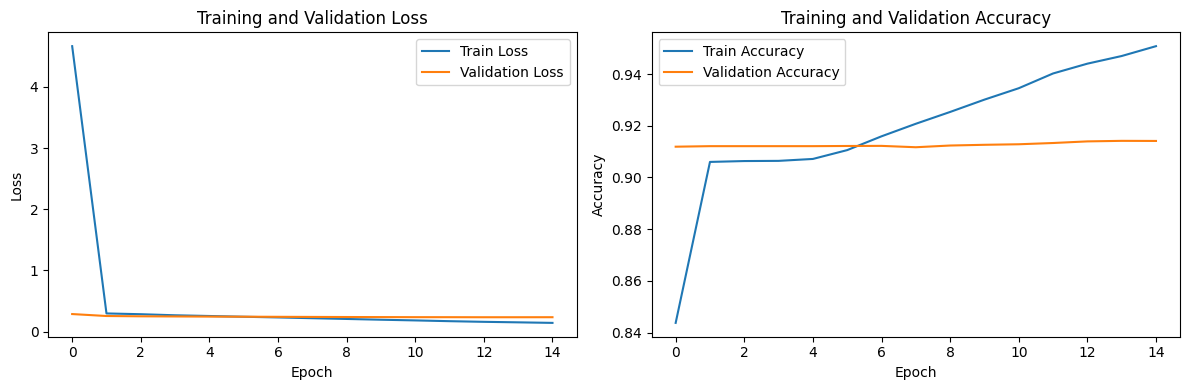

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# test_predictions, test_labels = predict(model, test_dataloader, device)
# test_accuracy = accuracy_score(test_labels, (test_predictions > 0.3).astype(int))
# test_f1 = f1_score(test_labels, (test_predictions > 0.1).astype(int), average='macro')

# print(f'\nTest Accuracy: {test_accuracy:.4f}')
# print(f'Test F1 Score: {test_f1:.4f}')



plot_metrics(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_predictions, test_labels = predict(model, test_dataloader, device)


binary_predictions = (test_predictions > 0.1).astype(int)

print("Classification Report:")
print(classification_report(test_labels, binary_predictions))

print("Confusion Matrix:")


Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.10      0.09        31
           1       0.19      0.68      0.30       106
           2       0.00      0.00      0.00         7
           3       0.49      0.53      0.51        75
           4       0.32      0.44      0.37        48
           5       0.33      0.98      0.49       247
           6       0.00      0.00      0.00        30
           7       0.25      0.25      0.25        48
           8       0.00      0.00      0.00         6
           9       0.50      0.10      0.16        21
          10       0.16      0.26      0.20        94
          11       0.41      0.99      0.58       309
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        13
          14       0.16      0.77      0.26        90
          15       1.00      0.06      0.11        18
          16       0.00      0.00      0.00        25
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
n, c = genre_tensor.shape

correct_predictions = 0
total_predictions = 0

for title_tensor, img_tensor, genre_tensor in test_dataloader:
    title_tensor = title_tensor.to(device)
    img_tensor = img_tensor.to(device)
    genre_tensor = genre_tensor.to(device)

    out = model(title_tensor, img_tensor)

    predicted_labels = torch.round(torch.sigmoid(out))

    correct_predictions += (predicted_labels == genre_tensor).sum().item()

    total_predictions += genre_tensor.numel()

accuracy = correct_predictions / total_predictions
print('Accuracy: ', accuracy)

Accuracy:  0.9141284141284142


In [ ]:
N, C = genre_tensor.shape

auroc_all = 0
f1_all = 0
f1 = MultilabelF1Score(num_labels=C, threshold=0.1, average='macro')
f1 = f1.to(device)
for title_tensor, img_tensor, genre_tensor in test_dataloader:
    title_tensor = title_tensor.to(device)
    img_tensor = img_tensor.to(device)
    genre_tensor = genre_tensor.to(device)

    out = model(title_tensor, img_tensor)
    f1_batch = f1(out, genre_tensor)
    f1_all += f1_batch

print('F1: ', f1_all/len(test_dataloader))

F1:  tensor(0.1758, device='cuda:0')


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

num_classes = len(genre_tensor[0])

all_true_labels = []
all_predicted_scores = []


for title_tensor, img_tensor, genre_tensor in test_dataloader:
    title_tensor = title_tensor.to(device)
    img_tensor = img_tensor.to(device)
    genre_tensor = genre_tensor.to(device)

    out = model(title_tensor, img_tensor)

    true_labels = genre_tensor.cpu().numpy()
    predicted_scores = out.cpu().detach().numpy()

    all_true_labels.append(true_labels)
    all_predicted_scores.append(predicted_scores)

all_true_labels = np.concatenate(all_true_labels)
all_predicted_scores = np.concatenate(all_predicted_scores)


precision_values = []
recall_values = []

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(all_true_labels[:, i], all_predicted_scores[:, i])

    precision_values.append(precision)
    recall_values.append(recall)

average_precision_per_class = [auc(recall, precision) for precision, recall in zip(precision_values, recall_values)]


map_at_k = np.mean(average_precision_per_class)

print('MAP@K:', map_at_k)
import torch
from PIL import Image
from torchvision import transforms

MAP@K: 0.21473653177850505
